# Zygo-OAP datx2FITS Wrangling
What it says on the tin.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits
import h5py
import copy

## OAP Data Sorting

In [11]:
Laird_raw = h5py.File('Zygo_data/Laird_OAP_15deg_10_27_2017_PTT.datx')
Laird_raw.visit(print)

Attributes
Attributes/System
Attributes/{0CC152D6-5F27-465D-BC8C-07224AEFADC6}
Data
Data/Surface
Data/Surface/{09B0108E-2498-4537-A466-9DF9FC6DA806}
Data/{3AD5CF24-EE4A-49B2-B550-DAEF948C76A6}
Data/{CF16554A-2933-469B-A8BF-CEB3B19FF82C}
MetaData
Processed Data: 
Processed Data: /PM-Gpi
Processed Data: /PM-Gpi/AP_DS:Processed Data
Processed Data: /PM-Gpi/AP_DS:Processed Data/Plot


In [13]:
#oap_file_location = 'Zygo_data/11_02_2017_OAP4_KVG_JL/11_02_2017_OAP4_processed_80percentCA_'
#test=5 # 5th measurement
oap_file = h5py.File('Zygo_data/Laird_OAP_15deg_10_27_2017_PTT.datx')
oap_header = fits.Header()
attr = oap_file['Processed Data: ']['PM-Gpi']['AP_DS:Processed Data']['Plot']['Attributes'].attrs
surf_data = oap_file['Processed Data: ']['PM-Gpi']['AP_DS:Processed Data']['Plot']['Surface'].value
oap_header['DATATYPE'] = ('PTT', 'Raw data or Zygo-processed data')
fits_file_loc = 'Zygo_data/LAIRD_OAP_PTT.fits'
scale_factor = attr.get('Data Context.Data Attributes.Interf Scale Factor:Value')[0]
test_wavelength = attr.get('Data Context.Data Attributes.Wavelength:Value')[0]
test_wavelength_units = attr.get('Data Context.Data Attributes.Wavelength:Unit')[0]
lateral_res = attr.get('Surface Data Context.Lateral Resolution:Value')[0]
lateral_res_units = attr.get('Surface Data Context.Lateral Resolution:Unit')[0]

# filter the surface data information and make a boolean mask base    
surf_value = copy.copy(surf_data) # do this to make sure everything isn't the same
row_side = np.shape(surf_value)[0]
col_side = np.shape(surf_value)[1]
mask = np.ones((row_side, col_side)) # the mask is all true initially
for row in range(0,row_side):
    for col in range(0,col_side):
        if np.absolute(surf_value[row][col]) > 10e3: #Zygo makes out-of-region values at e+308... whyyy
            mask[row][col] = 0; # logical false for the mask

# Fill in FITS header
oap_header['SCALE'] = (scale_factor, 'Zygo Interf Scale Factor, multiplied into data')
oap_header['WAVELEN'] = (test_wavelength, 'Zygo wavelength')
oap_header['WAVELENU'] = (str(test_wavelength_units), 'Zygo wavelength units')
oap_header['CADIAM'] = (0.0508, 'Clear Aperture Diameter, [meters]')
oap_header['MASKDIAM'] = (80, 'Percent value of clear aperture diameter')
oap_header['LATRES'] = (lateral_res, 'Lateral Resolution across mask diameter')
oap_header['LATRESU'] = (str(lateral_res_units), 'Lateral Resolution Units, [m/pix]')

# Write datx file to FITS file
fits.writeto(fits_file_loc, mask, oap_header, clobber=True)

In [8]:
raw_data = False
ptt_data = True

oap_file = h5py.File('Zygo_data/11_30_2017_FM_KVG_KM/flatmirror_processed_pttremoved.datx')

# initialize FITS header
oap_header = fits.Header()
oap_header['DATE'] = ('NOV 30 2017', 'Date of OAP measurement on Zygo')
oap_header['CADIAM'] = (0.0254, 'Clear Aperture Diameter, [meters]')
oap_header['MASKDIAM'] = (98, 'Percent value of clear aperture diameter')

# The attributes and surface data are in different locations depending on raw or Zygo-processed.
if raw_data==True and ptt_data==False:
    # get attributes list
    attr = oap_file['Measurement']['Attributes'].attrs
    # get the surface data
    surf_data = oap_file['Measurement']['Surface'].value
    # write FITS header
    oap_header['DATATYPE'] = ('RAW', 'Raw data or Zygo-processed data')
    # declare FITS file location
    fits_file_loc = 'FITS/FM/FM_RAW.fits'
elif raw_data==False and ptt_data==True:
    # get attributes list
    attr = oap_file['Processed Data: ']['PM-Gpi']['AP_DS:Processed Data']['Plot']['Attributes'].attrs
    # get surface data
    surf_data = oap_file['Processed Data: ']['PM-Gpi']['AP_DS:Processed Data']['Plot']['Surface'].value
    # write FITS header
    oap_header['DATATYPE'] = ('PTT', 'Raw data or Zygo-processed data')
    # declare FITS file location
    fits_file_loc = 'FITS/FM/FM_PTT.fits'
else:
    print('I do not know what kind of data we are looking at.')

# collect particular pieces of information
scale_factor = attr.get('Data Context.Data Attributes.Interf Scale Factor:Value')[0]
test_wavelength = attr.get('Data Context.Data Attributes.Wavelength:Value')[0]
test_wavelength_units = attr.get('Data Context.Data Attributes.Wavelength:Unit')[0]
lateral_res = attr.get('Surface Data Context.Lateral Resolution:Value')[0]
lateral_res_units = attr.get('Surface Data Context.Lateral Resolution:Unit')[0]

# filter the surface data information and make a boolean mask base    
surf_value = copy.copy(surf_data) # do this to make sure everything isn't the same
row_side = np.shape(surf_value)[0]
col_side = np.shape(surf_value)[1]
mask = np.ones((row_side, col_side)) # the mask is all true initially
for row in range(0,row_side):
    for col in range(0,col_side):
        if np.absolute(surf_value[row][col]) > 10e3: #Zygo makes out-of-region values at e+308... whyyy
            surf_value[row][col] = 0;
            mask[row][col] = 0; # logical false for the mask
# apply scale factor on the surface data
surf_value = surf_value * scale_factor

# add surface value to list for caliball averaging out
oap_surface.append(surf_value)

# calculate PV
pv = np.amax(surf_value) - np.amin(surf_value)

# calculate RMS
surface_mask = np.extract(mask, surf_value)
surface_rms = np.sqrt(np.sum(np.square(surface_mask))/len(surface_mask))

# Fill in FITS header
oap_header['SCALE'] = (scale_factor, 'Zygo Interf Scale Factor, multiplied into data')
oap_header['WAVELEN'] = (test_wavelength, 'Zygo wavelength')
oap_header['WAVELENU'] = (str(test_wavelength_units), 'Zygo wavelength units')
oap_header['LATRES'] = (lateral_res, 'Lateral Resolution across mask diameter')
oap_header['LATRESU'] = (str(lateral_res_units), 'Lateral Resolution Units, [m/pix]')
oap_header['RMS'] = (surface_rms, 'Measured across mask diameter; [waves]')
oap_header['PV'] = (pv, 'Peak-to-Valley measurement, [waves]')

# Write datx file to FITS file
fits.writeto(fits_file_loc, surf_value, oap_header, clobber=True)

In [5]:
#oap_file_location = 'Zygo_data/11_02_2017_OAP4_KVG_JL/11_02_2017_OAP4_processed_80percentCA_'
#test=5 # 5th measurement
oap_file = h5py.File('Zygo_data/11_30_2017_FM_KVG_KM/flatmirror_processed_pttremoved.datx')
oap_header = fits.Header()
attr = oap_file['Processed Data: ']['PM-Gpi']['AP_DS:Processed Data']['Plot']['Attributes'].attrs
surf_data = oap_file['Processed Data: ']['PM-Gpi']['AP_DS:Processed Data']['Plot']['Surface'].value
oap_header['DATATYPE'] = ('PTT', 'Raw data or Zygo-processed data')
fits_file_loc = 'Zygo_data/FM_PTT.fits'
scale_factor = attr.get('Data Context.Data Attributes.Interf Scale Factor:Value')[0]
test_wavelength = attr.get('Data Context.Data Attributes.Wavelength:Value')[0]
test_wavelength_units = attr.get('Data Context.Data Attributes.Wavelength:Unit')[0]
lateral_res = attr.get('Surface Data Context.Lateral Resolution:Value')[0]
lateral_res_units = attr.get('Surface Data Context.Lateral Resolution:Unit')[0]

# filter the surface data information and make a boolean mask base    
surf_value = copy.copy(surf_data) # do this to make sure everything isn't the same
row_side = np.shape(surf_value)[0]
col_side = np.shape(surf_value)[1]
mask = np.ones((row_side, col_side)) # the mask is all true initially
for row in range(0,row_side):
    for col in range(0,col_side):
        if np.absolute(surf_value[row][col]) > 10e3: #Zygo makes out-of-region values at e+308... whyyy
            mask[row][col] = 0; # logical false for the mask

# Fill in FITS header
oap_header['SCALE'] = (scale_factor, 'Zygo Interf Scale Factor, multiplied into data')
oap_header['WAVELEN'] = (test_wavelength, 'Zygo wavelength')
oap_header['WAVELENU'] = (str(test_wavelength_units), 'Zygo wavelength units')
oap_header['CADIAM'] = (0.0508, 'Clear Aperture Diameter, [meters]')
oap_header['MASKDIAM'] = (80, 'Percent value of clear aperture diameter')
oap_header['LATRES'] = (lateral_res, 'Lateral Resolution across mask diameter')
oap_header['LATRESU'] = (str(lateral_res_units), 'Lateral Resolution Units, [m/pix]')

# Write datx file to FITS file
fits.writeto(fits_file_loc, mask, oap_header, clobber=True)

In [4]:
oap_file_location = 'Zygo_data/11_02_2017_OAP4_KVG_JL/11_02_2017_OAP4_processed_80percentCA_'
test=5 # 5th measurement
oap_file = h5py.File(oap_file_location+str(test)+'.datx')
oap_header = fits.Header()
attr = oap_file['Processed Data: ']['PM-Gpi']['AP_DS:Processed Data']['Plot']['Attributes'].attrs
surf_data = oap_file['Processed Data: ']['PM-Gpi']['AP_DS:Processed Data']['Plot']['Surface'].value
oap_header['DATATYPE'] = ('PTT', 'Raw data or Zygo-processed data')
fits_file_loc = 'LAIRD_OAP'+str(test)+'.fits'
scale_factor = attr.get('Data Context.Data Attributes.Interf Scale Factor:Value')[0]
test_wavelength = attr.get('Data Context.Data Attributes.Wavelength:Value')[0]
test_wavelength_units = attr.get('Data Context.Data Attributes.Wavelength:Unit')[0]
lateral_res = attr.get('Surface Data Context.Lateral Resolution:Value')[0]
lateral_res_units = attr.get('Surface Data Context.Lateral Resolution:Unit')[0]

# filter the surface data information and make a boolean mask base    
surf_value = copy.copy(surf_data) # do this to make sure everything isn't the same
row_side = np.shape(surf_value)[0]
col_side = np.shape(surf_value)[1]
mask = np.ones((row_side, col_side)) # the mask is all true initially
for row in range(0,row_side):
    for col in range(0,col_side):
        if np.absolute(surf_value[row][col]) > 10e3: #Zygo makes out-of-region values at e+308... whyyy
            mask[row][col] = 0; # logical false for the mask

# Fill in FITS header
oap_header['SCALE'] = (scale_factor, 'Zygo Interf Scale Factor, multiplied into data')
oap_header['WAVELEN'] = (test_wavelength, 'Zygo wavelength')
oap_header['WAVELENU'] = (str(test_wavelength_units), 'Zygo wavelength units')
oap_header['CADIAM'] = (0.0508, 'Clear Aperture Diameter, [meters]')
oap_header['MASKDIAM'] = (80, 'Percent value of clear aperture diameter')
oap_header['LATRES'] = (lateral_res, 'Lateral Resolution across mask diameter')
oap_header['LATRESU'] = (str(lateral_res_units), 'Lateral Resolution Units, [m/pix]')

# Write datx file to FITS file
fits.writeto(fits_file_loc, mask, oap_header, clobber=True)

In [2]:
# Initialize the sets
oap_surface = []

num_oap_tests = 5

# PTT Data Location
#oap_file_location = 'Zygo_data/11_02_2017_OAP4_KVG_JL/11_02_2017_OAP4_processed_80percentCA_'
# CA = Clear Aperture
# Raw data location
#oap_file_location = 'Zygo_data/11_02_2017_OAP4_KVG_JL/11_02_2017_OAP4_80percentCA_'

raw_data = True
ptt_data = False

for test in range(1,num_oap_tests+1):
    # open file contents
    #oap_file = h5py.File(oap_file_location+str(test)+'.datx')
    oap_file = h5py.File('Zygo_data/10_16_17_OAPSurf/12_5'+str(test)+'_OAP_Mask_374pix.datx')
    
    # initialize FITS header
    oap_header = fits.Header()
    oap_header['DATE'] = ('OCT 16 2017', 'Date of OAP measurement on Zygo')
    
    # The attributes and surface data are in different locations depending on raw or Zygo-processed.
    if raw_data==True and ptt_data==False:
        # get attributes list
        attr = oap_file['Measurement']['Attributes'].attrs
        # get the surface data
        surf_data = oap_file['Measurement']['Surface'].value
        # write FITS header
        oap_header['DATATYPE'] = ('RAW', 'Raw data or Zygo-processed data')
        # declare FITS file location
        fits_file_loc = 'FITS/OAP4/V1/RAW/OAP4_raw_test'+str(test)+'.fits'
    elif raw_data==False and ptt_data==True:
        # get attributes list
        attr = oap_file['Processed Data: ']['PM-Gpi']['AP_DS:Processed Data']['Plot']['Attributes'].attrs
        # get surface data
        surf_data = oap_file['Processed Data: ']['PM-Gpi']['AP_DS:Processed Data']['Plot']['Surface'].value
        # write FITS header
        oap_header['DATATYPE'] = ('PTT', 'Raw data or Zygo-processed data')
        # declare FITS file location
        fits_file_loc = 'FITS/OAP4/V1/OAP4_PTT_test'+str(test)+'.fits'
    else:
        print('I do not know what kind of data we are looking at.')
        break
    
    # collect particular pieces of information
    scale_factor = attr.get('Data Context.Data Attributes.Interf Scale Factor:Value')[0]
    test_wavelength = attr.get('Data Context.Data Attributes.Wavelength:Value')[0]
    test_wavelength_units = attr.get('Data Context.Data Attributes.Wavelength:Unit')[0]
    lateral_res = attr.get('Surface Data Context.Lateral Resolution:Value')[0]
    lateral_res_units = attr.get('Surface Data Context.Lateral Resolution:Unit')[0]

    # filter the surface data information and make a boolean mask base    
    surf_value = copy.copy(surf_data) # do this to make sure everything isn't the same
    row_side = np.shape(surf_value)[0]
    col_side = np.shape(surf_value)[1]
    mask = np.ones((row_side, col_side)) # the mask is all true initially
    for row in range(0,row_side):
        for col in range(0,col_side):
            if np.absolute(surf_value[row][col]) > 10e3: #Zygo makes out-of-region values at e+308... whyyy
                surf_value[row][col] = 0;
                mask[row][col] = 0; # logical false for the mask
    # apply scale factor on the surface data
    surf_value = surf_value * scale_factor
    
    # add surface value to list for caliball averaging out
    oap_surface.append(surf_value)
    
    # calculate PV
    pv = np.amax(surf_value) - np.amin(surf_value)
    
    # calculate RMS
    surface_mask = np.extract(mask, surf_value)
    surface_rms = np.sqrt(np.sum(np.square(surface_mask))/len(surface_mask))
    
    # Fill in FITS header
    oap_header['SCALE'] = (scale_factor, 'Zygo Interf Scale Factor, multiplied into data')
    oap_header['WAVELEN'] = (test_wavelength, 'Zygo wavelength')
    oap_header['WAVELENU'] = (str(test_wavelength_units), 'Zygo wavelength units')
    oap_header['CADIAM'] = (0.0508, 'Clear Aperture Diameter, [meters]')
    oap_header['MASKDIAM'] = (80, 'Percent value of clear aperture diameter')
    oap_header['LATRES'] = (lateral_res, 'Lateral Resolution across mask diameter')
    oap_header['LATRESU'] = (str(lateral_res_units), 'Lateral Resolution Units, [m/pix]')
    oap_header['RMS'] = (surface_rms, 'Measured across mask diameter; [waves]')
    oap_header['PV'] = (pv, 'Peak-to-Valley measurement, [waves]')
    
    # Write datx file to FITS file
    fits.writeto(fits_file_loc, surf_value, oap_header, clobber=True)

In [3]:
np.shape(oap_surface)

(5, 376, 380)

## Calibrating out the caliball from OAP measurements
- BE VERY CAREFUL: Know what OAP surface set you're working with! (stay on track, Jhen!)

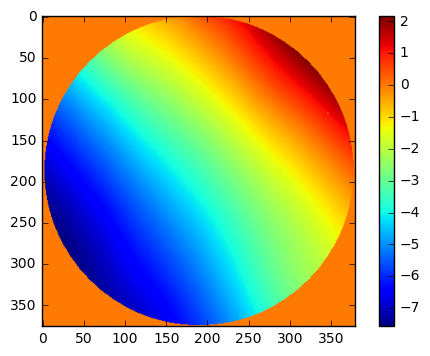

In [4]:
# convert to numpy array to work numpy
np_oap = np.asarray(oap_surface)

row_side = np.shape(oap_surface)[1]
col_side = np.shape(oap_surface)[2]

# initialize 
avg_surface = np.zeros((row_side, col_side))

for row in range(0,row_side):
    for col in range(0,col_side):
        avg_surface[row][col] = np.mean(np_oap[:,row,col])

# Calculate the RMS
avg_surf_mask = np.extract(mask, avg_surface)
avg_rms = np.sqrt(np.sum(np.square(avg_surf_mask))/len(avg_surf_mask))

# Calculate PV
avg_pv = np.amax(avg_surface) - np.amin(avg_surface)

# Overwrite some FITS header information
oap_header['RMS'] = (avg_rms, 'Measured across mask diameter; [waves]')
oap_header['PV'] = (avg_pv, 'Peak-to-Valley measurement, [waves]')
if raw_data==True and ptt_data==False:
    fits_file_loc = 'FITS/OAP4/OAP4_RAW_V1_avg5.fits'
elif raw_data==False and ptt_data==True:
    fits_file_loc = 'FITS/OAP4/OAP4_PTT_V1_avg5.fits'
fits.writeto(fits_file_loc, surf_value, oap_header, clobber=True)

# Show the surface map
plt.imshow(avg_surface)
plt.colorbar()

# REFERENCE
Exploring the datx files

## Data attributes listings

In [7]:
oap4_raw = h5py.File('Zygo_data/11_02_2017_OAP4_KVG_JL/11_02_2017_OAP4_80percentCA_4.datx')
oap4_raw.visit(print)

Attributes
Attributes/System
Attributes/{2C3F1CE0-DF00-4106-86C0-0A7D54A48E83}
Data
Data/Intensity
Data/Intensity/{31FBDA7B-A8BE-441C-87D8-2DD319F6DE00}
Data/Surface
Data/Surface/{542927E3-8E13-4082-B9AE-7E62036D8C1A}
Data/{3AD5CF24-EE4A-49B2-B550-DAEF948C76A6}
Data/{CF16554A-2933-469B-A8BF-CEB3B19FF82C}
Measurement
MetaData


In [9]:
Laird_raw = h5py.File('Zygo_data/Laird_OAP_15deg_10_27_2017.datx')
Laird_raw.visit(print)

Attributes
Attributes/System
Attributes/{96083C62-B134-4473-B23C-5F4981729DCF}
Data
Data/Intensity
Data/Intensity/{5805190F-F866-47AD-B556-070651031FC1}
Data/Surface
Data/Surface/{4EFD6BE7-A484-4588-92A7-B9928574BE80}
Data/{3AD5CF24-EE4A-49B2-B550-DAEF948C76A6}
Data/{CF16554A-2933-469B-A8BF-CEB3B19FF82C}
Measurement
MetaData


In [108]:
raw_attrs = oap4_raw['Measurement']['Attributes'].attrs
raw_list = list(raw_attrs) # the Attributes folder is hidden, sneaky...
raw_list

['Data Context.Data Attributes.AGC',
 'Data Context.Data Attributes.Acquisition Mode',
 'Data Context.Data Attributes.Average Minimum Valid',
 'Data Context.Data Attributes.Average Minimum Valid:Unit',
 'Data Context.Data Attributes.Average Minimum Valid:Value',
 'Data Context.Data Attributes.Camera Height',
 'Data Context.Data Attributes.Camera Height:Unit',
 'Data Context.Data Attributes.Camera Height:Value',
 'Data Context.Data Attributes.Camera Mode',
 'Data Context.Data Attributes.Camera Name',
 'Data Context.Data Attributes.Camera Width',
 'Data Context.Data Attributes.Camera Width:Unit',
 'Data Context.Data Attributes.Camera Width:Value',
 'Data Context.Data Attributes.Connect Algorithm',
 'Data Context.Data Attributes.Connect Maximum Area',
 'Data Context.Data Attributes.Connect Maximum Area:Value',
 'Data Context.Data Attributes.Connect Minimum Area',
 'Data Context.Data Attributes.Connect Minimum Area:Value',
 'Data Context.Data Attributes.Connect Noise Threshold',
 'Data Con

In [7]:
oap4_ptt = h5py.File('Zygo_data/11_02_2017_OAP4_KVG_JL/11_02_2017_OAP4_processed_80percentCA_4.datx')
oap4_ptt.visit(print)

Attributes
Attributes/System
Attributes/{F8E0032C-FE60-4659-A98D-747A270F3022}
Data
Data/Surface
Data/Surface/{EA87170C-0F6E-47B8-A90B-3637A48F0BD1}
Data/{3AD5CF24-EE4A-49B2-B550-DAEF948C76A6}
Data/{CF16554A-2933-469B-A8BF-CEB3B19FF82C}
MetaData
Processed Data: 
Processed Data: /PM-Gpi
Processed Data: /PM-Gpi/AP_DS:Processed Data
Processed Data: /PM-Gpi/AP_DS:Processed Data/Plot


In [8]:
ptt_attrs = oap4_ptt['Processed Data: ']['PM-Gpi']['AP_DS:Processed Data']['Plot']['Attributes'].attrs
ptt_list = list(ptt_attrs) # the Attributes folder is hidden, sneaky...
ptt_list

['Data Context.Data Attributes.AGC',
 'Data Context.Data Attributes.Acquisition Mode',
 'Data Context.Data Attributes.Average Minimum Valid',
 'Data Context.Data Attributes.Average Minimum Valid:Unit',
 'Data Context.Data Attributes.Average Minimum Valid:Value',
 'Data Context.Data Attributes.Camera Height',
 'Data Context.Data Attributes.Camera Height:Unit',
 'Data Context.Data Attributes.Camera Height:Value',
 'Data Context.Data Attributes.Camera Mode',
 'Data Context.Data Attributes.Camera Name',
 'Data Context.Data Attributes.Camera Width',
 'Data Context.Data Attributes.Camera Width:Unit',
 'Data Context.Data Attributes.Camera Width:Value',
 'Data Context.Data Attributes.Connect Algorithm',
 'Data Context.Data Attributes.Connect Maximum Area',
 'Data Context.Data Attributes.Connect Maximum Area:Value',
 'Data Context.Data Attributes.Connect Minimum Area',
 'Data Context.Data Attributes.Connect Minimum Area:Value',
 'Data Context.Data Attributes.Connect Noise Threshold',
 'Data Con

In [9]:
units = ptt_attrs.get('Data Context.Data Attributes.Wavelength:Unit')[0]
units

b'Meters'

In [10]:
type(units)

bytes

In [11]:
str_units = str(units)
type(str_units)

str

In [12]:
str_units

"b'Meters'"

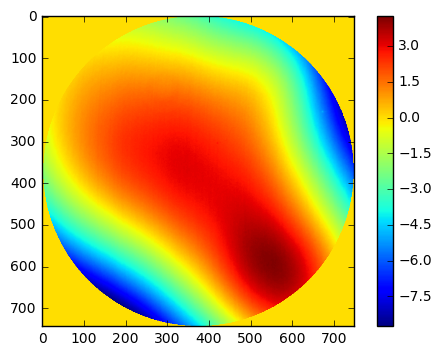

In [41]:
filter_surf = copy.copy(proc_surf)
# do for loop investigation
row_side = np.shape(filter_surf)[0]
col_side = np.shape(filter_surf)[1]
for row in range(0,row_side):
    for col in range(0,col_side):
        if np.absolute(filter_surf[row][col]) > 10e3:
            filter_surf[row][col] = 0;
# Show the surface map
plt.imshow(filter_surf)
plt.colorbar()

rewrite the nasty outside values with a for loop

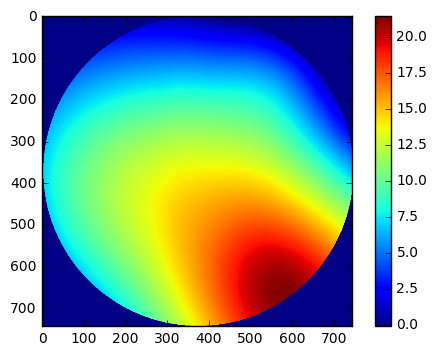

In [26]:
# do for loop investigation
side = np.shape(oap5)[0]
for row in range(0,side):
    for col in range(0,side):
        if np.absolute(oap5[row][col]) > 10e3:
            oap5[row][col] = 0;
# Show the surface map
plt.imshow(oap5)
plt.colorbar()